# 3D Convolutional Neural Network
In this notebook, we build a 3D Convolutional Neural Network to classify voxelized point cloud pairs as either "similar" (1) or "dissimilar" (0). The data consists of pairs of voxelized point clouds along with corresponding labels. We use a shared-weight Siamese architecture for this purpose.

## Step 1: Import Required Libraries
First, we need to import necessary libraries for data processing, neural network creation, and training.

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import csv


## Step 2: Voxelization Function
The following function takes a point cloud and voxelizes it into a 64x64x64 grid. This function will be used to convert the point cloud data into a format suitable for the 3D CNN.

In [11]:
def voxelize(pc):
    # Normalize point cloud data
    point_cloud = (pc - pc.min(axis=0)) / (pc.max(axis=0) - pc.min(axis=0))
    voxel_size = 32
    voxelized = np.zeros((voxel_size, voxel_size, voxel_size))
    point_cloud = ((voxel_size - 1) * point_cloud).astype(int)
    voxelized[point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]] = 1
    return voxelized


## Step 3: Custom Dataset Class
We define a custom Dataset class that:
- Loads pairs of voxelized point clouds from `.npy` files.
- Uses the voxelization function to convert the point clouds.
- Converts the voxelized data to PyTorch tensors.

The dataset is loaded from the `curated_data` directory.

In [12]:
class VoxelDataset(Dataset):
    def __init__(self, file_list, data_directory, subset_size=None):
        self.data_directory = data_directory
        self.file_list = file_list
        if subset_size is not None:
            self.file_list = self.file_list[:subset_size]  # Use only a subset of files 

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_directory, self.file_list[idx])
        data = np.load(file_path, allow_pickle=True)
        part1, part2, label = data

        # Voxelizing the point clouds
        voxel1 = voxelize(part1)
        voxel2 = voxelize(part2)

        # Convert to tensors
        voxel1 = torch.tensor(voxel1, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        voxel2 = torch.tensor(voxel2, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(label, dtype=torch.float32)

        return voxel1, voxel2, label

## Step 4: Split the Dataset into Training, Validation, and Test Sets
We split the dataset into **70% training**, **15% validation**, and **15% test** to evaluate model performance effectively.

In [13]:
# Define data directory
data_directory = os.path.join(os.getcwd(), "curated_data/")

# Get all files in the directory
all_files = [f for f in os.listdir(data_directory) if f.endswith('.npy')]

# Split data into train, validation, and test sets
# Tunable:
# train_test_split `test_size`: Controls the proportion of data used for validation and test sets.
# A smaller test_size keeps more data for training, which may improve model learning at the cost of less validation data.
train_files, test_files = train_test_split(all_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)  # Further split to validation and test

# Create Dataset instances
# Corrected to pass the list of filenames along with the directory path
train_dataset = VoxelDataset(train_files, data_directory)  # Pass list of training files and the directory path
val_dataset = VoxelDataset(val_files, data_directory)      # Pass list of validation files and the directory path
test_dataset = VoxelDataset(test_files, data_directory)    # Pass list of test files and the directory path

# Create DataLoaders for each dataset
batch_size = 128 # Tunable parameter: Increasing batch size can improve efficiency, but requires more memory.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Step 5: 3D Encoder Module
We define the 3D Encoder model that:
- Uses 3D convolutional layers to extract features from the voxelized input.
- Contains several layers and prints the shape after each layer for debugging purposes.

In [14]:
class Encoder3D(nn.Module):
    def __init__(self):
        super(Encoder3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, stride=1, padding=1) # Tunable: Number of filters (4). More filters may capture more features but are computationally expensive. Make changes in progressions like 2, 4, 8, 16, 32,...
        self.conv2 = nn.Conv3d(4, 8, kernel_size=3, stride=2, padding=1)  # Tunable: Number of filters (8). Increasing may improve feature extraction at the cost of increased computation.
        #self.conv3 = nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(8 * 16 * 16 * 16, 32)  # Tunable: Output features (32). Increasing this can capture more complex relationships but increases model complexity.

        self.first_forward = True  # Flag to track the first forward pass
    def forward(self, x):
        x = F.relu(self.conv1(x))
        if self.first_forward:
            print(f"Shape after conv1: {x.shape}")
        x = F.relu(self.conv2(x))
        if self.first_forward:
            print(f"Shape after conv2: {x.shape}")
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        if self.first_forward:
            print(f"Shape after flattening: {x.shape}")
        x = self.fc(x)
        if self.first_forward:
            print(f"Shape after fc: {x.shape}")
            self.first_forward = False  # Disable further shape printing after the first forward pass
        return x



## Step 6: Siamese Network for Pair Comparison
The Siamese Network is built using two instances of the shared encoder. It compares the output of both encoders using L1 distance and computes a similarity score.

In [15]:
class Siamese3DCNN(nn.Module):
    def __init__(self):
        super(Siamese3DCNN, self).__init__()
        self.encoder = Encoder3D()
        self.fc_out = nn.Linear(32, 1)  # Tunable: Number of input features (32). Match this to the output of the encoder.
        

    def forward(self, voxel1, voxel2):
        encoded1 = self.encoder(voxel1)
        encoded2 = self.encoder(voxel2)

        # Compute the L1 distance between the two encoded vectors
        combined = torch.abs(encoded1 - encoded2)

        # Pass through fully connected layer to get a single value
        output = self.fc_out(combined)

        # Apply sigmoid to produce a probability output
        output = torch.sigmoid(output)

        return output



## Step 7: Training Setup
We define the training function to train the Siamese network. It uses Binary Cross Entropy Loss (BCE Loss) to classify the similarity.

We include a **validation phase** at the end of each training epoch to monitor the model's performance.
Training and validation losses are stored for graphing.


In [16]:
def train_model_with_validation(num_epochs, learning_rate, batch_size, validate_every_n_epochs):
    model = Siamese3DCNN()
    criterion = nn.BCELoss() # Tunable: Loss function. Experimenting with other losses (e.g., MSELoss) could impact model behavior.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Tunable: Trying other optimizers (e.g., SGD) can change convergence behavior.

    # Lists to store losses for graphing
    training_losses = []
    validation_losses = []

    # Updated DataLoader with increased batch size and more workers for data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        start_time = time.time()

        for voxel1, voxel2, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(voxel1, voxel2)
            labels = labels.view(-1, 1)  # Ensure labels match output shape
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        end_time = time.time()
        print(f"\nEpoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.6f}, Time Taken: {end_time - start_time:.2f}s")

        # Validation Phase (every N epochs)
        if (epoch + 1) % validate_every_n_epochs == 0: # Tunable: Frequency of validation checks
            model.eval()
            val_loss = 0.0
            start_time = time.time()

            with torch.no_grad():
                for voxel1, voxel2, labels in val_loader:
                    outputs = model(voxel1, voxel2)
                    labels = labels.view(-1, 1)  # Ensure labels match output shape
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            end_time = time.time()
            print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.6f}, Validation Time Taken: {end_time - start_time:.2f}s")
    
    # Save the trained model
    model_save_path = "3d_cnn_model.pth"  # Filepath where model will be saved
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    return model, training_losses, validation_losses

# Tunable parameters:
    # `num_epochs`: Increasing number of epochs gives the model more opportunities to learn but risks overfitting.
    # `learning_rate`: A smaller learning rate (0.001) helps the model converge slowly and stably. Higher rates (e.g., 0.01) may lead to faster but unstable convergence.
    # `batch_size`: Larger batch sizes help with convergence and are faster but need more memory.
    # `validate_every_n_epochs`: Controls how often to validate. Less frequent validation speeds up training.
# Run the training with updated parameters
model, training_losses, validation_losses = train_model_with_validation(num_epochs=5, learning_rate=0.001, batch_size=128, validate_every_n_epochs=1)

Shape after conv1: torch.Size([128, 4, 32, 32, 32])
Shape after conv2: torch.Size([128, 8, 16, 16, 16])
Shape after flattening: torch.Size([128, 32768])
Shape after fc: torch.Size([128, 32])

Epoch [1/5], Training Loss: 0.300483, Time Taken: 154.32s
Epoch [1/5], Validation Loss: 0.214384, Validation Time Taken: 13.27s

Epoch [2/5], Training Loss: 0.114065, Time Taken: 152.15s
Epoch [2/5], Validation Loss: 0.180350, Validation Time Taken: 13.34s

Epoch [3/5], Training Loss: 0.087304, Time Taken: 150.63s
Epoch [3/5], Validation Loss: 0.183327, Validation Time Taken: 13.21s

Epoch [4/5], Training Loss: 0.044786, Time Taken: 152.05s
Epoch [4/5], Validation Loss: 0.226853, Validation Time Taken: 13.36s

Epoch [5/5], Training Loss: 0.034629, Time Taken: 151.50s
Epoch [5/5], Validation Loss: 0.233947, Validation Time Taken: 13.57s
Model saved to 3d_cnn_model.pth


## Step 8: Run Training
Now, we can train the model using the dataset. Make sure to specify the correct data directory.
Plot the losses recorded during training and validation to visualize how the model's performance evolves over time.

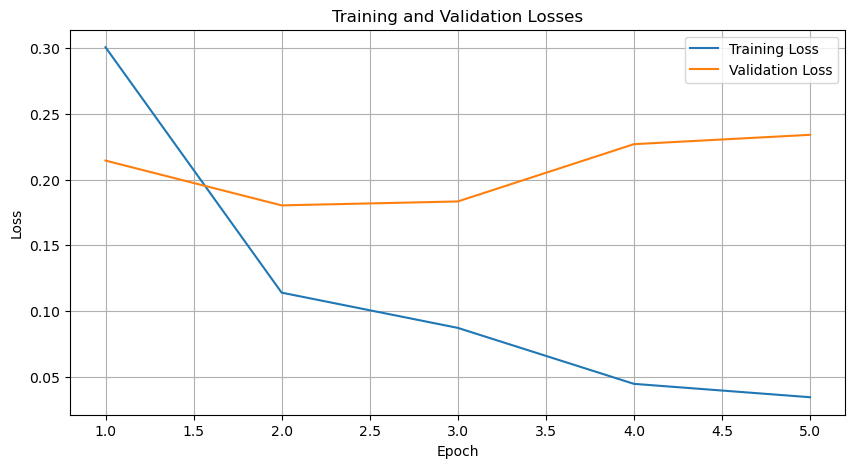

In [17]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()